<h3>Data Importing</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/deependran7/Datasets/master/hourly_data.csv')
I_r = data.ghi.to_list()
Q = data.discharge.to_list()
P_load = data.p.to_list()
Q_load = data.q.to_list()
K_load = data.kva.to_list()
w_speed = data.wind_speed.to_list()
data = data.set_index('date')

In [3]:
class Hydro_model:
    mhp_cc = 1777
    mhp_om = 53.31
    Q_des = 0
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    
    def __init__(self, eta_mhp,gamma,q,h):
        self.eta_mhp = eta_mhp
        self.gamma = gamma
        self.q = q
        self.h = h
    def set_Q_des(self, Q_des):
        self.Q_des = Q_des
    def set_H_des(self,h):
        self.h = h
    def Power(self):
        power = [0]*len(self.q)
        for k in range(len(self.q)):
            if self.q[k] <= self.Q_des:
                power[k] = self.eta_mhp*self.gamma*self.q[k]*self.h
            else:
                power[k] = self.eta_mhp*self.gamma*self.Q_des*self.h
        return np.array(power)
    def Cost(self):
        Power = self.eta_mhp*self.gamma*self.Q_des*self.h
        return Power*(self.mhp_cc + self.mhp_om/self.crf);

In [4]:
class PV_model:
    pv_cc = 618;
    pv_om = 10;
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    
    def __init__(self, N_pv,I_r):
        self.N_pv = N_pv
        self.I_r = I_r
    def Power(self):
        power = [0]*len(self.I_r)
        for k in range(len(self.I_r)):
            power[k] = self.N_pv*(self.I_r[k]/1000)
        return np.array(power)
    def Cost(self):
        return self.N_pv * (self.pv_cc +self.pv_om/self.crf);

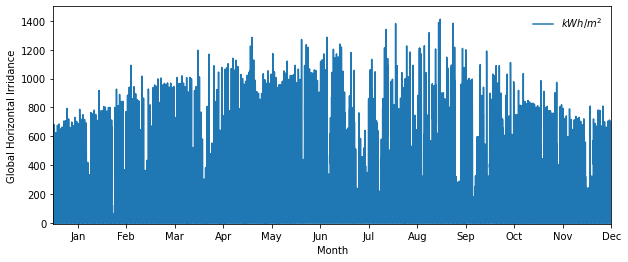

In [5]:
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']
x = np.arange(730/2,730*12, 730)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(I_r)
plt.xlim([0, 7*24])
plt.ylim(-5,1500)
plt.xlabel('Month')
plt.ylabel('Global Horizontal Irridance')
plt.grid(False)
ax1.legend(['$kWh/m^2$'],loc='upper right',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('solar.jpeg',bbox_inches = 'tight',dpi = 300)
plt.show()
#files.download('solar.png')

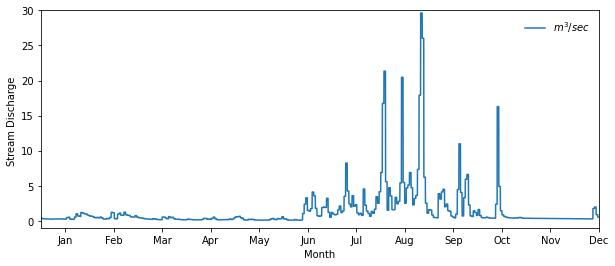

In [ ]:
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']
x = np.arange(730/2,730*12, 730)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(Q)
plt.xlim([0, 7*24])
plt.ylim(-1,30)
plt.xlabel('Month')
plt.ylabel('Stream Discharge ')
plt.grid(False)
ax1.legend(['$m^3/sec$'],loc='upper right',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('discharge.jpeg',bbox_inches = 'tight',dpi = 300)
plt.show()
#files.download('discharge.png')

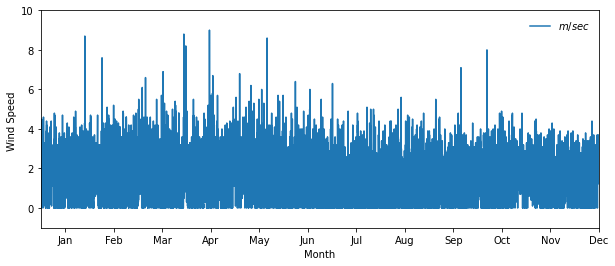

In [ ]:
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']
x = np.arange(730/2,730*12, 730)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(w_speed)
plt.xlim([0, 7*24])
plt.ylim(-1,10)
plt.xlabel('Month')
plt.ylabel('Wind Speed ')
plt.grid(False)
ax1.legend(['$m/sec$'],loc='upper right',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('wind_speed.jpeg',bbox_inches = 'tight')
plt.show()
#files.download('discharge.png')

In [ ]:
len(data)/12

730.0833333333334

In [ ]:
class Load_model:
    def __init__(self, load_profile,factor):
        self.loading = np.array(load_profile)*factor
    def Power(self):
        return self.loading

In [ ]:
pload = Load_model(P_load,0.4)
qload = Load_model(Q_load,0.4)
sload = Load_model(K_load,0.4)

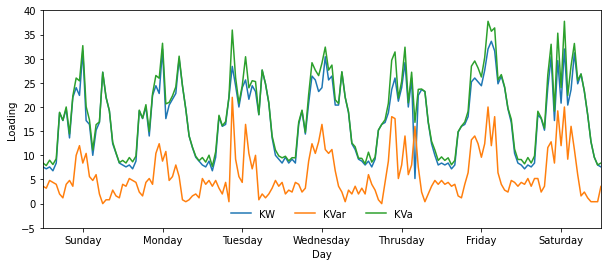

In [ ]:
labels = ['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']
x = np.arange(12,7*24, 24)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(pload.Power())
plt.plot(qload.Power())
plt.plot(sload.Power())
plt.xlim([0, 7*24])
plt.ylim(-5,40)
plt.xlabel('Day')
plt.ylabel('Loading')
plt.grid(False)
ax1.legend(['KW', 'KVar', 'KVa'],loc='lower center',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('loading.jpeg',bbox_inches = 'tight',dpi = 300)
plt.show()
#files.download('loading.png')

In [ ]:
class Battery_model:
    sigma = 0.0001
    eta_inv = 0.9
    eta_bd = 0.9
    eta_bc = 0.9
    C_b = 2.42
    DOD = 0.8
    Soc = [0.5]*8761
    P_bat = [0]*8761
    nb_cc = 200
    nb_om = 0
    nb_rep = 200
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    
    def __init__(self, N_b,Delta_P):
        self.N_b  = N_b
        self.Delta_P = Delta_P
    
    def SOC(self):
        for k in range(1,len(self.Delta_P)):
            if self.Delta_P[k-1] > 0:
                if self.Soc[k-1] >=1:
                    self.Soc[k] = 1
                    
                else:
                    if self.Delta_P[k-1] >=self.N_b*self.C_b:
                        power = self.N_b*self.C_b
                        self.Soc[k] = self.Soc[k-1]*(1-self.sigma) + (power)*self.eta_bc/(self.N_b*self.C_b)
                        
                    else:
                        power = self.Delta_P[k-1]
                        self.Soc[k] = self.Soc[k-1]*(1-self.sigma) + (power)*self.eta_bc/(self.N_b*self.C_b)
                        
                if self.Soc[k]>=1:
                    self.Soc[k] = 1
                   
            if self.Delta_P[k-1] < 0:
                if (self.Soc[k-1])<= (1-self.DOD):
                    self.Soc[k] = 1-self.DOD
                    
                else:
                    self.Soc[k] = self.Soc[k-1]*(1-self.sigma)+ self.Delta_P[k-1]/(self.eta_bd*self.N_b*self.C_b)
                    self.P_bat[k]=-self.Delta_P[k]
                if (self.Soc[k] <=(1-self.DOD)):
                    self.Soc[k] = 1-self.DOD
        return np.array(self.Soc)
      

    def Power(self):
      self.SOC()
      for k in range(1,len(self.Delta_P)):
        if self.Soc[k-1] >= self.Soc[k]:
          #battery discharges
          self.P_bat[k-1] = (self.Soc[k-1]-self.Soc[k]*(1-self.sigma))*self.eta_bd*self.N_b*self.C_b 
        else:
          #battery charges
          self.P_bat[k-1] = (self.Soc[k-1]-self.Soc[k]*(1-self.sigma))*self.eta_bc*self.N_b*self.C_b 
      return np.array(self.P_bat)
    
    def calc_rep(self):
      return (1/(1+self.dr)**5 + 1/(1+self.dr)**10 + 1/(1+self.dr)**15 + 1/(1+self.dr)**20)
    
    def Cost(self):
        return self.N_b * (self.nb_cc +self.nb_om/self.crf) + self.N_b * self.nb_rep * self.calc_rep() ;
    

In [ ]:
class ELC:
    elc_r = 0
    cc_elc= 150
    om_elc=150*5/100
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    def __init__(self,load,battery,*Power_sources):
        self.Power_sources = Power_sources
        self.load = load
        self.battery = battery
        
    def Power(self):
        residual_power = 0
        for power_source in self.Power_sources:
            residual_power = residual_power + power_source.Power()
        return residual_power-self.load.Power()+self.battery.Power()
    def Cost(self):
        self.elc_r = max(self.Power())
        return (self.elc_r*self.cc_elc + self.om_elc * self.elc_r/self.crf )  

In [ ]:
class Inverter_model:
  eta_inv = 0.98
  inv_cc = 200
  inv_om = 0
  inv_rep = 200
  dr = 0.1;
  def __init__(self, Battery_model, pf):
    self.Battery_model = Battery_model
    self.pf  = pf

  def Power(self):
    return self.Battery_model.Power()*self.eta_inv
  
  def calc_rep(self):
      return (1/(1+self.dr)**10 + 1/(1+self.dr)**20)

  def calc_kva(self):
    return self.Battery_model.N_b * self.Battery_model.C_b/self.pf
  def Cost(self):
    return (self.inv_cc * self.calc_kva() +self.inv_rep*self.calc_kva()*self.calc_rep()) 

<h3>Optimisation Algorithmis</h3>
<h5>We are using Memetic Algrithm, particle swarm optimisation, genetic algorithm and articifical bee cololy optimisation</h5>

In [ ]:
pip install --upgrade mealpy 

     |████████████████████████████████| 286kB 7.7MB/s 
     |████████████████████████████████| 7.5MB 13.1MB/s 


In [ ]:
from mealpy.evolutionary_based.GA import BaseGA
from mealpy.swarm_based.PSO import BasePSO
from mealpy.swarm_based.ABC import BaseABC

In [ ]:
def Loss_function(x=None):
    hydro = Hydro_model(0.5,9.8,Q,30)
    hydro.set_Q_des(x[1])
    hydro.set_H_des(x[2])
    solar = PV_model(x[0], I_r)
    load = Load_model(P_load,0.4)
    delta_P = hydro.Power() + solar.Power() - load.Power()
    battery = Battery_model(x[3],delta_P)
    elc = ELC(load,battery,hydro,solar)
    inv = Inverter_model(battery, 0.85)
    outage = 0
    el = elc.Power()
    for k in range(len(I_r)):
        out = el[k]
        if out < 0:
            outage = outage + 1
    #print(outage) 
    if (outage) == 0:
        z = hydro.Cost() + solar.Cost() + battery.Cost() + inv.Cost()
        return z
    else:
        return 100000000
   

In [ ]:
lb = [0,  0.0, 1, 0]
ub = [50, 2.0, 40,60]
problem_size = 100
batch_size = 10
verbose = True
epoch = 200
pop_size = 100

In [ ]:
md = BaseMA(Loss_function, lb, ub, verbose, epoch, pop_size)
best_pos, best_fit, list_loss = md.train()
MA_sol = {
  "name": "MA",
  "best_pos": best_pos,
  "best_fit": best_fit,
  "list_loss": list_loss
}

In [ ]:
md = BaseGA(Loss_function, lb, ub, verbose, epoch, pop_size)
best_pos, best_fit, list_loss = md.train()
GA_sol = {
  "name": "GA",
  "best_pos": best_pos,
  "best_fit": best_fit,
  "list_loss": list_loss
}

In [ ]:
md = BasePSO(Loss_function, lb, ub, verbose, epoch, pop_size)
best_pos, best_fit, list_loss = md.train()
PSO_sol = {
  "name": "PSO",
  "best_pos": best_pos,
  "best_fit": best_fit,
  "list_loss": list_loss
}

In [ ]:
md = BaseABC(Loss_function, lb, ub, verbose, epoch, pop_size)
best_pos, best_fit, list_loss = md.train()
ABC_sol = {
  "name": "ABC",
  "best_pos": best_pos,
  "best_fit": best_fit,
  "list_loss": list_loss
}

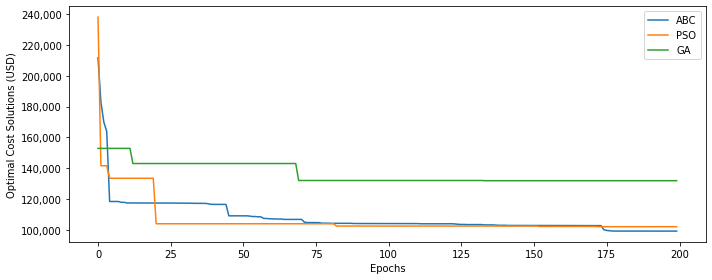

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,4)
ax.plot(ABC_sol['list_loss'])
ax.plot(PSO_sol['list_loss'])
ax.plot(GA_sol['list_loss'])
ax.legend(['ABC','PSO','GA'])
plt.xlabel('Epochs')
plt.ylabel('Optimal Cost Solutions (USD)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.savefig('algorithm_comparsion.png',bbox_inches = 'tight')
plt.show()
files.download('algorithm_comparsion.png')

In [ ]:
sol_data = pd.DataFrame()
sol_data['ABC'] = ABC_sol['list_loss']
sol_data['PSO'] = PSO_sol['list_loss']
sol_data['GA'] = GA_sol['list_loss']

In [ ]:
sol_data.to_csv('stt_opt_sol.csv')

In [ ]:
a = ABC_sol.get('best_pos')
print(a)

[12.21413162  0.12120023 39.62723023 25.7872984 ]


In [ ]:
a = [12.21413162,  0.12120023, 39.62723023 ,25.7872984 ]

In [ ]:
print(Loss_function(a))

96741.5699368582


<h3>Sharing Analysis for a typical day with curtailment</h3>

In [ ]:
PV_size = a[0];
q_des = a[1];
h_des = a[2];
NB = a[3];
hydro = Hydro_model(0.5,9.8,Q,30)
hydro.set_Q_des(a[1])
hydro.set_H_des(a[2])
solar = PV_model(a[0], I_r)
load = Load_model(P_load,0.4)
delta_P = hydro.Power() + solar.Power() - load.Power()
battery = Battery_model(a[3],delta_P)
elc = ELC(load,battery,solar,hydro)

In [ ]:
plot_data = pd.DataFrame()
plot_data['P_solar'] = solar.Power()
plot_data['P_mhp']=hydro.Power()
plot_data['P_load']= load.Power()
plot_data['SOC'] = battery.SOC()
plot_data['P_bat']=battery.Power()
plot_data['P_elc']=elc.Power()

In [ ]:
columns = ['P_mhp', 'P_solar', 'P_load','P_elc']
power_data = pd.DataFrame(plot_data, columns=columns)

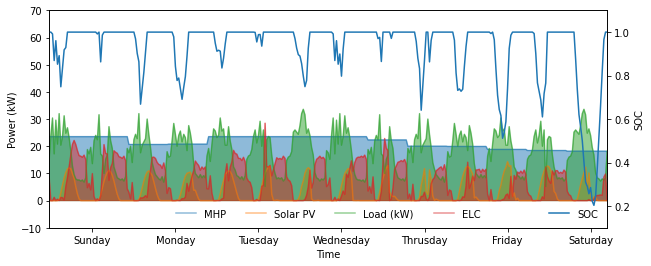

In [ ]:
labels = ['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']
x = np.arange(3050,3351, 50)
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
power_data.plot.area(xlim =[9*14*24, 10*14*24], ylim =[-10, 70], ax = ax1, stacked = False)


ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.legend(['MHP','Solar PV', 'Load (kW)', 'ELC'],loc='lower center',frameon=False, ncol=5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plot_data.SOC.plot(xlim =[9*14*24, 10*14*24], ylim =[0.1, 1.1], ax = ax2)
ax2.set_ylabel('SOC')
ax2.legend(['SOC'],loc ='lower right',frameon = False)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

plt.savefig('sharing.jpeg',bbox_inches = 'tight',dpi=300)
plt.show()
#files.download('sharing.png')

In [ ]:
soc_d = plot_data.query('SOC<0.5')
len(soc_d)/len(plot_data)

0.01917589316288095

In [ ]:
ssoc = plot_data.SOC.to_list()

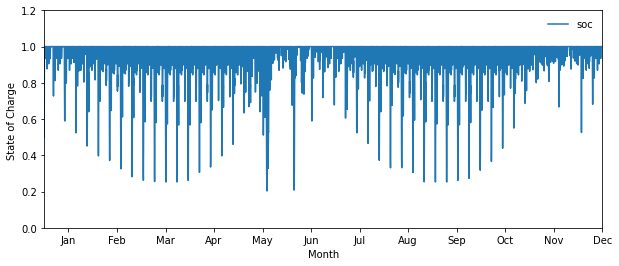

In [ ]:
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']
x = np.arange(730/2,730*12, 730)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(ssoc)
plt.xlim([0, 7*24])
plt.ylim(0,1.2)
plt.xlabel('Month')
plt.ylabel('State of Charge ')
plt.grid(False)
ax1.legend(['soc'],loc='upper right',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('soc.jpeg',bbox_inches = 'tight',dpi=300)
plt.show()
#files.download('discharge.png')

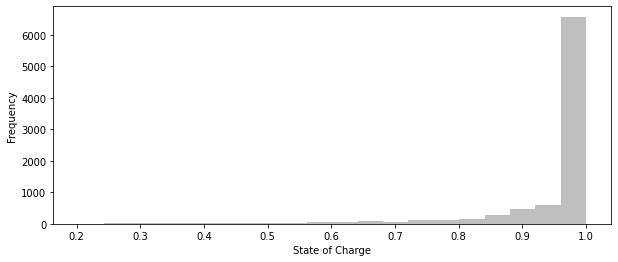

In [ ]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.hist(ssoc, bins = 20, color='0.75')
plt.xlabel('State of Charge')
plt.ylabel('Frequency')
plt.savefig('soc_hist.jpeg',bbox_inches = 'tight',dpi = 300)
plt.show()

In [ ]:
yearly_revenu_st = plot_data.P_load.sum() * 8.1/120
yearly_revenu_ns = 148984.39999999895*8.1/120

In [ ]:
P_elc = elc.Power()
elc_power = []
dif_power = []
for i in range(len(P_elc)):
  a = P_elc[i];
  if a>0:
    elc_power.append(a)
  if a<0:
    dif_power.append(a)
print(sum(elc_power))
print(sum(dif_power))
print(plot_data.P_load.sum() )


69873.35951599453
0
154220.0


In [ ]:
hydro = Hydro_model(0.5,9.8,Q,26)
hydro.set_Q_des(a[1])
hydro.set_H_des(a[2])
hy_om = hydro.Power().max()
inv = Inverter_model(battery, 0.85)
bat = a[3]
elcc = elc.Power().max()
om_cost_st = hy_om * 1777*0.05 + a[0]*10 + elcc*150*0.05
investment_st = hy_om*1777 + a[0] * 618 + inv.Power().max()*200 + bat*200 + elcc*150
bat_rep = 200*bat
inv_rep = 200*inv.Power().max()

In [ ]:
a = [ 3.71109123 , 0.17352174, 39.79990894]
hydro = Hydro_model(0.5,9.8,Q,26)
hydro.set_Q_des(a[1])
hydro.set_H_des(a[2])
elc_size = 32.86
hy_om = hydro.Power().max()
om_cost_ns = hy_om * 1777*0.05 + a[0]*10 + elc_size*150*0.05
investment_ns = hy_om*1777 + a[0] * 618 + elc_size*150


In [ ]:
bar_value_st = [0]*25
bar_value_st[0] = -investment_st
for i in range(1,len(bar_value_st)):
  bar_value_st[i] = yearly_revenu_st-om_cost_st
#battery and inverter replacement
bar_value_st[4] = yearly_revenu_st-om_cost_st - bat_rep
bar_value_st[9] = yearly_revenu_st-om_cost_st - bat_rep - inv_rep
bar_value_st[14] = yearly_revenu_st-om_cost_st - bat_rep
bar_value_st[19] = yearly_revenu_st-om_cost_st - bat_rep - inv_rep
bar_value_st[24] = yearly_revenu_st-om_cost_st - bat_rep


In [ ]:
bar_value_ns = [0]*25
bar_value_ns[0] = -investment_ns
for i in range(1,len(bar_value_ns)):
  bar_value_ns[i] = yearly_revenu_ns-om_cost_ns

In [ ]:
#finding internal rate of return
a= 0
for n in np.arange(0.01,0.15,0.001):
  eq = 0
  for i in range(1,len(bar_value_ns)):
    factor = (1+n)**i
    eq = eq + bar_value_ns[i]/factor
  if eq >= abs(bar_value_ns[0]):
    a = n
  else:
    continue
print(a)


0.08599999999999992


In [ ]:
#fining discounted pay back period 
eq = 0
a= 0
for i in range(1,len(bar_value_ns)):
  factor = (1+0.07)**i
  eq = eq + bar_value_ns[i]/factor
  if eq>= abs(bar_value_ns[0]):
    a = i
    break
  else:
    continue
print(a)

18


In [ ]:
bar_value_ns[0]

-67356.36949579322

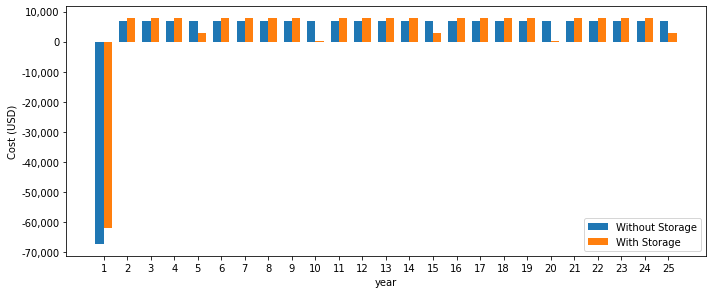

In [ ]:
import matplotlib
labels = bar_value_ns
men_means = bar_value_ns
women_means = bar_value_st
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,4)
x = np.arange(1,len(labels)+1)  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, men_means, width, label='Without Storage')
rects2 = ax.bar(x + width/2, women_means, width, label='With Storage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost (USD)')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.xlabel('year')
plt.savefig('cashflow.jpeg',bbox_inches = 'tight',dpi = 300)
plt.show()
#files.download('cashflow.png')

In [ ]:
#finding benefit cost ratio
dr = 0.07;
n = 25;

ns_i = -bar_value_ns[0]
ns_annutity_p = 0
for i in range(1,len(bar_value_ns)):
  crf = (1+dr)**i
  ns_annutity_p = ns_annutity_p + bar_value_ns[i]/crf

st_i = -bar_value_st[0]
st_annutity_p = 0
for i in range(1,len(bar_value_st)):
  crf = (1+dr)**i
  st_annutity_p = st_annutity_p + bar_value_st[i]/crf

In [ ]:
bcr_ns = ns_annutity_p/ns_i
print("bcr_ns",bcr_ns)
bcr_st = st_annutity_p/st_i
print("bcr_st",bcr_st)

bcr_ns 1.152135980757189
bcr_st 1.2575949120739143


In [ ]:
lb = [0,  0.0, 1, 0]
ub = [50, 2.0, 40,60]
problem_size = 100
batch_size = 10
verbose = True
epoch = 200
pop_size = 100

Sensitivity Analysis

In [ ]:
sol = []
outtt = []

In [ ]:
for i in range(0,120,20):
  def Loss_function1(x=None):
      hydro = Hydro_model(0.5,9.8,Q,30)
      hydro.set_Q_des(x[1])
      hydro.set_H_des(x[2])
      solar = PV_model(x[0], I_r)
      load = Load_model(P_load,0.4)
      delta_P = hydro.Power() + solar.Power() - load.Power()
      battery = Battery_model(x[3],delta_P)
      elc = ELC(load,battery,hydro,solar)
      inv = Inverter_model(battery, 0.85)
      outage = 0
      el = elc.Power()
      for k in range(len(I_r)):
          out = el[k]
          if out < 0:
              outage = outage + 1
      #print(outage) 
      if (outage-i) <= 0:
          z = hydro.Cost() + solar.Cost() + battery.Cost() + inv.Cost()
          return z
      else:
          return 100000000

  md = BaseABC(Loss_function1, lb, ub, verbose, epoch, pop_size)
  best_pos, best_fit, list_loss = md.train()
  ABC_sol1 = {
    "name": "ABC",
    "best_pos": best_pos,
    "best_fit": best_fit,
    "list_loss": list_loss
  }
  sol.append(ABC_sol1.get('best_pos'))
  outtt.append(i)

>Epoch: 1, patch_size: 4.925, Best fit: 166441.19437825418


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

dataf = pd.DataFrame()
dataf['optimal'] = sol
dataf['outage'] = outtt
dataf.to_csv('part1st.csv')
files.download('part1st.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def Loss_function2(i,x=None):
      hydro = Hydro_model(0.5,9.8,Q,30)
      hydro.set_Q_des(x[1])
      hydro.set_H_des(x[2])
      solar = PV_model(x[0], I_r)
      load = Load_model(P_load,0.4)
      delta_P = hydro.Power() + solar.Power() - load.Power()
      battery = Battery_model(x[3],delta_P)
      elc = ELC(load,battery,hydro,solar)
      inv = Inverter_model(battery, 0.85)
      outage = 0
      el = elc.Power()
      for k in range(len(I_r)):
          out = el[k]
          if out < 0:
              outage = outage + 1
      #print(outage) 
      if (outage-i) <= 0:
          z = hydro.Cost() + solar.Cost() + battery.Cost() + inv.Cost() + elc.Cost()
          return z
      else:
          return 100000000


In [ ]:
def calc_lcoe(x):
  hydro = Hydro_model(0.5,9.8,Q,30)
  hydro.set_Q_des(x[1])
  hydro.set_H_des(x[2])
  solar = PV_model(x[0], I_r)
  load = Load_model(P_load,0.4)
  delta_P = hydro.Power() + solar.Power() - load.Power()
  battery = Battery_model(x[3],delta_P)
  elc = ELC(load,battery,hydro,solar)
  inv = Inverter_model(battery, 0.85)
  el = elc.Power()
  p= 0
  for i in range(len(I_r)):
    if el[i]>=0:
      p = p+load.Power()[i]

  hydro_size =hydro.Power().max()
  pv_size = x[0]
  battery_size= x[3]
  inv_size= inv.Power().max()
  elc_size = el.max()

  hydro_cost = 1777*1
  hydro_om_cost = 0.05*1777 *1
  pv_cost=680*1
  pv_om_cost=10*1
  battery_cost = 200*1
  inv_cost = 200*1
  elc_cost = 150*1
  elc_om = 0.05*150*1
  dr = 0.1
  n= 25
  crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
  battery_rep_cost= 200 
  inv_rep_cost= 200

  bat_rep = (1/(1+dr)**5 + 1/(1+dr)**10 + 1/(1+dr)**15 + 1/(1+dr)**20 +  1/(1+dr)**25) 
  inv_rep = (1/(1+dr)**10 + 1/(1+dr)**20)

  E_annual = p
  
  pvcost = (hydro_cost*hydro_size + pv_cost * pv_size + battery_size*battery_cost  + inv_size*inv_cost + elc_cost*elc_size + battery_size*battery_cost*bat_rep+inv_size*inv_cost*inv_rep)*crf  + hydro_size*hydro_om_cost + pv_size*pv_om_cost + elc_size*elc_om 

  lcoe2  = pvcost/E_annual
  return lcoe2

In [ ]:
dataf = pd.read_csv('drive/MyDrive/gdrive_folder/st.csv', doublequote= True)

In [ ]:
def stra(strx):
    arr = []
    
    for a in strx.split(' '):
        newstr = ''
        try:
            for i in range(len(a)):
                if a[i] !='[' and a[i] !=']' and a[i] != ',':
                    newstr = newstr + a[i]
            newstr = float(newstr)   
            arr.append(newstr)
        except:
            pass
    return arr

In [ ]:
cost = [0]*26
lcoe = [0]*26
for i in range(len(dataf)):
  a = stra(dataf.optimal[i])
  out= dataf.outage[i]
  cc = Loss_function2(out,a)
  if cc < 1000000:
    cost[i] = cc
    lcoe[i] = calc_lcoe(a)
  else:
    cost[i] = 10000000
    lcoe[i] = 100
dataf['cost'] = cost
dataf['lcoe'] = lcoe

154219.99999999892
153683.5999999989
153165.19999999896
152625.59999999896
152144.7999999989
151206.79999999882
150934.79999999882
150465.19999999885
150354.39999999895
149153.19999999876
148886.3999999987
148025.5999999987
147397.99999999854
146999.99999999875
147017.99999999863
145901.59999999867
144991.19999999861
144117.59999999855
144289.9999999986
144501.1999999985
143506.7999999987
143119.19999999853
142374.3999999985
141101.5999999987
141981.59999999852
140583.59999999852


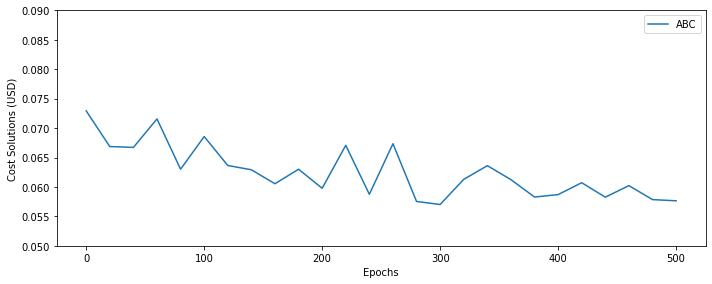

In [ ]:
import matplotlib
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,4)

ax.plot(dataf.outage, dataf.lcoe)
ax.legend(['ABC','PSO','GA', 'MA'])
plt.xlabel('Epochs')
plt.ylabel('Cost Solutions (USD)')
#ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.ylim([0.05, 0.09])
#plt.savefig('algorithm_comparsion_ns.png',bbox_inches = 'tight')
plt.show()

In [ ]:
dataf.to_csv('storage.csv')
files.download('storage.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

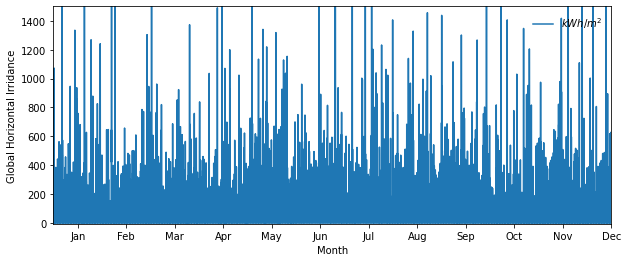

In [ ]:
#stochastic analysis
from scipy.stats import norm,lognorm
A = []
for k in I_r:
  if k != 0.0:
    A.append(k)

mu = lognorm.fit(A)
#generating random number using lognorm 
#for generation uncertaninty analysis
def create_rand_I_r(mu,I_rr):
  I_rdata = [0]*len(I_rr)
  for i in range(len(I_rr)):
    if I_rr[i] !=0:
      I_rdata[i] = np.random.lognormal(mu)[0]
  return I_rdata
I_rdata = create_rand_I_r(mu,I_r)

labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']
x = np.arange(730/2,730*12, 730)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
plt.plot(I_rdata)
plt.xlim([0, 7*24])
plt.ylim(-5,1500)
plt.xlabel('Month')
plt.ylabel('Global Horizontal Irridance')
plt.grid(False)
ax1.legend(['$kWh/m^2$'],loc='upper right',frameon=False, ncol=3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.savefig('solar.png',bbox_inches = 'tight')
plt.show()
#files.download('solar.png')

In [ ]:
def Loss_functions(x=None):
    hydro = Hydro_model(0.5,9.8,Q,30)
    hydro.set_Q_des(x[1])
    hydro.set_H_des(x[2])
    solar = PV_model(x[0], I_rr)
    load = Load_model(P_load,0.4)
    delta_P = hydro.Power() + solar.Power() - load.Power()
    battery = Battery_model(x[3],delta_P)
    elc = ELC(load,battery,hydro,solar)
    inv = Inverter_model(battery, 0.85)
    outage = 0
    el = elc.Power()
    for k in range(len(I_rr)):
        out = el[k]
        if out < 0:
            outage = outage + 1
    #print(outage) 
    if (outage) == 0:
        z = hydro.Cost() + solar.Cost() + battery.Cost() + inv.Cost()
        return z
    else:
        return 100000000

In [ ]:
lb = [0,  0.0, 1, 0]
ub = [50, 2.0, 40,60]
batch_size = 10
verbose = True
epoch = 200
pop_size = 100

In [ ]:
solutions = []
cost=[]
for i in range(50):
  print('iteraion',i)
  I_rr = create_rand_I_r(mu,I_r)
  md = BaseABC(obj_func = Loss_functions,lb = lb , ub = ub, verbose = True,epoch = epoch,pop_size= pop_size)
  best_pos, best_fit, list_loss = md.train()
  ABC_sol = {
    "name": "ABC",
    "best_pos": best_pos,
    "best_fit": best_fit,
    "list_loss": list_loss
  }
  a = ABC_sol.get('best_pos')
  b = ABC_sol.get('best_fit')
  solutions.append(a)
  print(a)
  cost.append(b)
  print(b)